In [1]:
import findspark
findspark.init()

In [2]:
import happybase
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("zad") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/01/06 22:20:22 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/06 22:20:22 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/06 22:20:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
VM_adress = 'localhost'
table_name = 'projekt'

In [4]:
def encode_if_not_none(value):
    return str(value).encode('utf-8') if value is not None else None

In [5]:
def return_cf_for_col(col, structure):
    for key, value in structure.items():
        if col in value:
            return key
    return None
    

In [6]:
def connect():
    VM_adress = 'localhost'
    connection = happybase.Connection(VM_adress, timeout=None)
    table = connection.table(table_name)
    return table

In [7]:
def print_table(limit = None):
    table = connect()
    
    for key, data in table.scan(None):
        print(f'KEY: {key}')
        for column, value in data.items():
            print(f'\tCOLUMNS: {column} VALUE: {value}')

In [8]:
print_table()

KEY: b'rowAFR1147_2023-12-31 13:05:00'
	COLUMNS: b'flight:aircraft_iata' VALUE: b'BCS3'
	COLUMNS: b'flight:aircraft_icao' VALUE: b'BCS3'
	COLUMNS: b'flight:aircraft_icao24' VALUE: b'39E686'
	COLUMNS: b'flight:aircraft_registration' VALUE: b'F-HZUG'
	COLUMNS: b'flight:airline_iata' VALUE: b'AF'
	COLUMNS: b'flight:airline_icao' VALUE: b'AFR'
	COLUMNS: b'flight:airline_name' VALUE: b'Air France'
	COLUMNS: b'flight:arrival_actual_runway' VALUE: b'2023-12-31T13:15:00+00:00'
	COLUMNS: b'flight:arrival_airport' VALUE: b'Frederic Chopin'
	COLUMNS: b'flight:arrival_day' VALUE: b'31'
	COLUMNS: b'flight:arrival_delay' VALUE: b'10'
	COLUMNS: b'flight:arrival_estimated' VALUE: b'2023-12-31 15:35:00'
	COLUMNS: b'flight:arrival_iata' VALUE: b'CDG'
	COLUMNS: b'flight:arrival_icao' VALUE: b'LFPG'
	COLUMNS: b'flight:arrival_month' VALUE: b'12'
	COLUMNS: b'flight:arrival_scheduled' VALUE: b'2023-12-31 15:35:00'
	COLUMNS: b'flight:arrival_terminal' VALUE: b'2F'
	COLUMNS: b'flight:arrival_timezone' VALUE: 

In [9]:
import pandas as pd
def get_rows_by_column_value(table, column_family, column_qualifier, value= '', target_columns = []):
    # Create a filter expression
    if value!='':
        filter_str = f"SingleColumnValueFilter('{column_family}', '{column_qualifier}', =, 'binary:{value}')"
        # print(filter_str)
    
        # Apply the filter expression to the scanner
        scanner = table.scan(filter=filter_str)
    else:
        scanner = table.scan()

    # Iterate through the results
    rows = []
    for key, data in scanner:
        temp = {}
        for column in target_columns:
            try:
                temp[column] = data[column]
                # print(data[column])
            except:
                temp[column] = 0
        # print(temp)
        
        rows.append(temp)
    df = pd.DataFrame(rows)
    return df

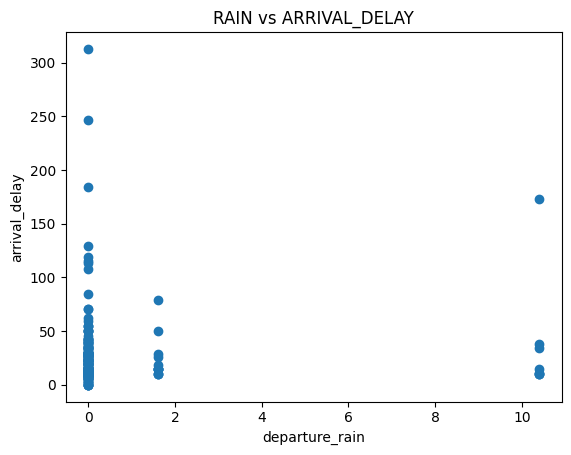

In [10]:
def get_flights_from_airport(departure_iata, target_columns):
    table = connect()
    return get_rows_by_column_value(table, 'flight', 'departure_iata', departure_iata, target_columns)

df = get_flights_from_airport("WAW", [b'flight:arrival_delay', b'weather:departure_rain'])
df.columns = ['arrival_delay', 'departure_rain']
df.arrival_delay = df.arrival_delay.apply(lambda x: int(x))
df.departure_rain = df.departure_rain.apply(lambda x: float(x))


import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(data = df, y = 'arrival_delay', x = 'departure_rain')
plt.ylabel('arrival_delay')
plt.xlabel('departure_rain')
plt.title("RAIN vs ARRIVAL_DELAY")
plt.show()



In [11]:
table = connect()
print_table()

KEY: b'rowAFR1147_2023-12-31 13:05:00'
	COLUMNS: b'flight:aircraft_iata' VALUE: b'BCS3'
	COLUMNS: b'flight:aircraft_icao' VALUE: b'BCS3'
	COLUMNS: b'flight:aircraft_icao24' VALUE: b'39E686'
	COLUMNS: b'flight:aircraft_registration' VALUE: b'F-HZUG'
	COLUMNS: b'flight:airline_iata' VALUE: b'AF'
	COLUMNS: b'flight:airline_icao' VALUE: b'AFR'
	COLUMNS: b'flight:airline_name' VALUE: b'Air France'
	COLUMNS: b'flight:arrival_actual_runway' VALUE: b'2023-12-31T13:15:00+00:00'
	COLUMNS: b'flight:arrival_airport' VALUE: b'Frederic Chopin'
	COLUMNS: b'flight:arrival_day' VALUE: b'31'
	COLUMNS: b'flight:arrival_delay' VALUE: b'10'
	COLUMNS: b'flight:arrival_estimated' VALUE: b'2023-12-31 15:35:00'
	COLUMNS: b'flight:arrival_iata' VALUE: b'CDG'
	COLUMNS: b'flight:arrival_icao' VALUE: b'LFPG'
	COLUMNS: b'flight:arrival_month' VALUE: b'12'
	COLUMNS: b'flight:arrival_scheduled' VALUE: b'2023-12-31 15:35:00'
	COLUMNS: b'flight:arrival_terminal' VALUE: b'2F'
	COLUMNS: b'flight:arrival_timezone' VALUE: 

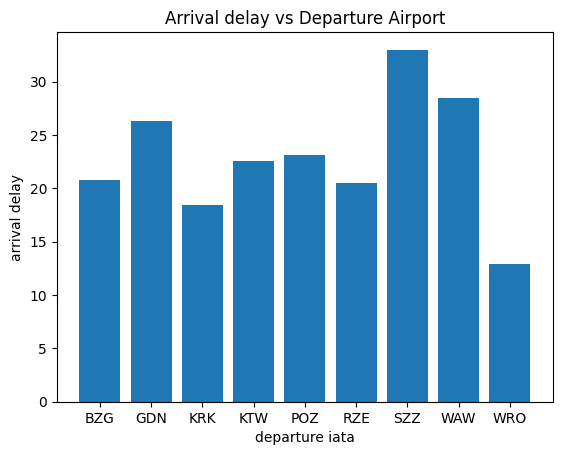

In [12]:
def get_delays(target_columns):
    table = connect()
    return get_rows_by_column_value(table, 'flight', 'departure_iata', '', target_columns = target_columns)

df = get_delays([b'flight:departure_iata', b'flight:arrival_delay'])
df.columns = ['departure_iata', 'arrival_delay']
df.departure_iata = df.departure_iata.apply(lambda x: x.decode('utf-8'))
df.arrival_delay = df.arrival_delay.apply(lambda x: float(x))
df = df.groupby(['departure_iata']).agg({
    'arrival_delay' : 'mean'
}).reset_index()

plt.bar(data = df, x = 'departure_iata', height = 'arrival_delay')
plt.ylabel('arrival delay')
plt.xlabel('departure iata')

plt.title('Arrival delay vs Departure Airport')
plt.show()